In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%cd ..

/home/den/dev/git/ozon-e-cup-2025


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import src.preprocessing as prep

In [ ]:
# Read tables with presense flags
train = pd.read_csv("data/train_with_flags.csv")
test = pd.read_csv("data/test_with_flags.csv")

# Utils funcs

In [ ]:
def count_empty_nan_emptystr(df, col):
    return {"NaN": df[col].isna().sum(), "empty_string": (df[col] == "").sum(), "total_rows": len(df)}


def analyze_string_columns(series):
    n_nan = series.isna().sum()
    n_empty = (series == "").sum()

    print("count:", len(series))
    print("n_nan:", n_nan)
    print("n_empty:", n_empty)
    print("n_non_empty:", len(series) - n_nan - n_empty)

    if series.dtype == object:
        lengths = series.dropna().apply(len)
        print("length_min:", lengths.min() if not lengths.empty else None)
        print("length_max:", lengths.max() if not lengths.empty else None)
        print("length_mean:", lengths.mean() if not lengths.empty else None)
        print("length_median:", lengths.median() if not lengths.empty else None)
        print("length_std:", lengths.std() if not lengths.empty else None)


def count_and_percentage_in(series_a, series_b):
    """
    Calculate how many values from series_a are also present in series_b.
    Returns a tuple: (count, percentage)
    """
    set_b = set(series_b.dropna().unique())
    mask = series_a.dropna().isin(set_b)
    count = mask.sum()
    percentage = count / len(series_a.dropna()) * 100 if len(series_a.dropna()) > 0 else 0
    return count, percentage


def analyze_numeric_series(s: pd.Series, bins, after_transform: bool = False):

    if not after_transform:
        print(f"Mean: {s.mean():.2f}")
        print(f"Median: {s.median():.2f}")
        print(f"Standard Deviation: {s.std():.2f}")
        print(f"Missing Values: {s.isna().sum()}")
        print(f"Percentage of NaN: {s.isna().mean() * 100:.2f}%")

        plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(s.dropna(), bins=bins)
        plt.title("Original Scale")
        plt.subplot(1, 2, 2)
        plt.hist(np.log1p(s.dropna()), bins=bins)
        plt.title("Log1p Scale")
        plt.show()
    else:
        print("Stats Without -1")
        print(f"Mean: {s[s != -1].mean():.2f}")
        print(f"Median: {s[s != -1].median():.2f}")
        print(f"Standard Deviation: {s[s != -1].std():.2f}")
        print(f"Missing Values: {s[s != -1].isna().sum()}")
        print(f"Percentage of NaN: {s[s != -1].isna().mean() * 100:.2f}%")

        plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(s.dropna(), bins=bins)
        plt.title("All values")
        plt.subplot(1, 2, 2)
        plt.hist(s[s != -1], bins=bins)
        plt.title("Without -1")
        plt.show()

# Look at columns

In [ ]:
len(train), len(test)

(197198, 22760)

In [ ]:
train_cols = set(train.columns)
test_cols = set(test.columns)
print("Columns in train but not in test:", train_cols - test_cols)
print("Columns in test but not in train:", test_cols - train_cols)

Columns in train but not in test: {'resolution'}
Columns in test but not in train: set()


In [ ]:
train.columns

Index(['resolution', 'brand_name', 'description', 'name_rus',
       'CommercialTypeName4', 'rating_1_count', 'rating_2_count',
       'rating_3_count', 'rating_4_count', 'rating_5_count',
       'comments_published_count', 'photos_published_count',
       'videos_published_count', 'PriceDiscounted', 'item_time_alive',
       'item_count_fake_returns7', 'item_count_fake_returns30',
       'item_count_fake_returns90', 'item_count_sales7', 'item_count_sales30',
       'item_count_sales90', 'item_count_returns7', 'item_count_returns30',
       'item_count_returns90', 'GmvTotal7', 'GmvTotal30', 'GmvTotal90',
       'ExemplarAcceptedCountTotal7', 'ExemplarAcceptedCountTotal30',
       'ExemplarAcceptedCountTotal90', 'OrderAcceptedCountTotal7',
       'OrderAcceptedCountTotal30', 'OrderAcceptedCountTotal90',
       'ExemplarReturnedCountTotal7', 'ExemplarReturnedCountTotal30',
       'ExemplarReturnedCountTotal90', 'ExemplarReturnedValueTotal7',
       'ExemplarReturnedValueTotal30', 'Exempl

In [ ]:
print(train.dtypes)

resolution                        int64
brand_name                       object
description                      object
name_rus                         object
CommercialTypeName4              object
rating_1_count                  float64
rating_2_count                  float64
rating_3_count                  float64
rating_4_count                  float64
rating_5_count                  float64
comments_published_count        float64
photos_published_count          float64
videos_published_count          float64
PriceDiscounted                 float64
item_time_alive                   int64
item_count_fake_returns7          int64
item_count_fake_returns30         int64
item_count_fake_returns90         int64
item_count_sales7                 int64
item_count_sales30                int64
item_count_sales90                int64
item_count_returns7               int64
item_count_returns30              int64
item_count_returns90              int64
GmvTotal7                       float64


In [ ]:
print("Is 'ItemID' unique in train?", train["ItemID"].is_unique)
print("Is 'ItemID' unique in test?", test["ItemID"].is_unique)

Is 'ItemID' unique in train? True
Is 'ItemID' unique in test? True


In [ ]:
target_col = "resolution"
id_cols = [
    "ItemID",  # уникальный идентификатор товара, в обучении не используем
]
boolean_cols = [
    "has_image",
    "has_description",
    "has_brand_name",
]
text_cols = [  # по тектовым колонкdам считаем фичи + tf-idf + возможно сконкатенируем (вместе brand_name, CommercialTypeName4) и сделаем эмбеддинг
    "description",  # мб Nan: добавил флаг
    "name_rus",  # всегда есть и не пусто как в train так и в test
]
categorial_cols = [
    "brand_name",  # мб Nan: добавил флаг
    "CommercialTypeName4",  # всегда есть и не пусто как в train так и в test
    "SellerID",  # всегда есть и не пусто как в train так и в test
]
numeric_cols = [  # числовые фичи, NaN значения заменяем на -1 (перед Scaler)
    "rating_1_count",
    "rating_2_count",
    "rating_3_count",
    "rating_4_count",
    "rating_5_count",
    "comments_published_count",
    "photos_published_count",
    "videos_published_count",
    "PriceDiscounted",
    "item_time_alive",
    "item_count_fake_returns7",
    "item_count_fake_returns30",
    "item_count_fake_returns90",
    "item_count_sales7",
    "item_count_sales30",
    "item_count_sales90",
    "item_count_returns7",
    "item_count_returns30",
    "item_count_returns90",
    "GmvTotal7",
    "GmvTotal30",
    "GmvTotal90",
    "ExemplarAcceptedCountTotal7",
    "ExemplarAcceptedCountTotal30",
    "ExemplarAcceptedCountTotal90",
    "OrderAcceptedCountTotal7",
    "OrderAcceptedCountTotal30",
    "OrderAcceptedCountTotal90",
    "ExemplarReturnedCountTotal7",
    "ExemplarReturnedCountTotal30",
    "ExemplarReturnedCountTotal90",
    "ExemplarReturnedValueTotal7",
    "ExemplarReturnedValueTotal30",
    "ExemplarReturnedValueTotal90",
    "ItemVarietyCount",
    "ItemAvailableCount",
    "seller_time_alive",
]

In [ ]:
# Check that all columns from train (except target) are included in one of the lists
all_feature_cols = set(id_cols + boolean_cols + numeric_cols + text_cols + categorial_cols)
missing_cols = set(train.columns) - all_feature_cols - {target_col}
print("Columns in train not included in any feature list:", missing_cols)

Columns in train not included in any feature list: set()


In [ ]:
# Analyze NaN, empty and whitespace-only strings

print("train 'name_rus':", count_empty_nan_emptystr(train, "name_rus"))
print("test 'name_rus':", count_empty_nan_emptystr(test, "name_rus"))
print()
print("train 'description':", count_empty_nan_emptystr(train, "description"))
print("test 'description':", count_empty_nan_emptystr(test, "description"))
print()
print("train 'brand_name':", count_empty_nan_emptystr(train, "brand_name"))
print("test 'brand_name':", count_empty_nan_emptystr(test, "brand_name"))
print()
print("train 'CommercialTypeName4':", count_empty_nan_emptystr(train, "CommercialTypeName4"))
print("test 'CommercialTypeName4':", count_empty_nan_emptystr(test, "CommercialTypeName4"))

train 'name_rus': {'NaN': np.int64(0), 'empty_string': np.int64(0), 'total_rows': 197198}
test 'name_rus': {'NaN': np.int64(0), 'empty_string': np.int64(0), 'total_rows': 22760}

train 'description': {'NaN': np.int64(26060), 'empty_string': np.int64(0), 'total_rows': 197198}
test 'description': {'NaN': np.int64(2224), 'empty_string': np.int64(0), 'total_rows': 22760}

train 'brand_name': {'NaN': np.int64(80531), 'empty_string': np.int64(0), 'total_rows': 197198}
test 'brand_name': {'NaN': np.int64(5832), 'empty_string': np.int64(0), 'total_rows': 22760}

train 'CommercialTypeName4': {'NaN': np.int64(0), 'empty_string': np.int64(0), 'total_rows': 197198}
test 'CommercialTypeName4': {'NaN': np.int64(0), 'empty_string': np.int64(0), 'total_rows': 22760}


In [ ]:
print(train.isnull().sum())

resolution                           0
brand_name                       80531
description                      26060
name_rus                             0
CommercialTypeName4                  0
rating_1_count                  150005
rating_2_count                  150005
rating_3_count                  150005
rating_4_count                  150005
rating_5_count                  150005
comments_published_count        150005
photos_published_count          150005
videos_published_count          150005
PriceDiscounted                      0
item_time_alive                      0
item_count_fake_returns7             0
item_count_fake_returns30            0
item_count_fake_returns90            0
item_count_sales7                    0
item_count_sales30                   0
item_count_sales90                   0
item_count_returns7                  0
item_count_returns30                 0
item_count_returns90                 0
GmvTotal7                        10191
GmvTotal30               

In [ ]:
print(test.isnull().sum())

brand_name                       5832
description                      2224
name_rus                            0
CommercialTypeName4                 0
rating_1_count                  21053
rating_2_count                  21053
rating_3_count                  21053
rating_4_count                  21053
rating_5_count                  21053
comments_published_count        21053
photos_published_count          21053
videos_published_count          21053
PriceDiscounted                     3
item_time_alive                     0
item_count_fake_returns7            0
item_count_fake_returns30           0
item_count_fake_returns90           0
item_count_sales7                   0
item_count_sales30                  0
item_count_sales90                  0
item_count_returns7                 0
item_count_returns30                0
item_count_returns90                0
GmvTotal7                        1381
GmvTotal30                        913
GmvTotal90                        759
ExemplarAcce

# Препроцессинг

## Textual

### description

In [ ]:
# Посмотрим на description

print("Train 'description':")
analyze_string_columns(train.description)
print()
print("Test 'description':")
analyze_string_columns(test.description)

Train 'description':
count: 197198
n_nan: 26060
n_empty: 0
n_non_empty: 171138
length_min: 1
length_max: 1024
length_mean: 411.61205576785983
length_median: 554.0
length_std: 244.91077362325473

Test 'description':
count: 22760
n_nan: 2224
n_empty: 0
n_non_empty: 20536
length_min: 1
length_max: 1024
length_mean: 487.180901830931
length_median: 568.0
length_std: 189.59859960577654


Обрезаны до 1024.

## Categorial

### brand_name

In [ ]:
# Посмотрим на brand_name

print("Train 'brand_name':")
analyze_string_columns(train.brand_name)
print()
print("Test 'brand_name':")
analyze_string_columns(test.brand_name)

Train 'brand_name':


count: 197198
n_nan: 80531
n_empty: 0
n_non_empty: 116667
length_min: 1
length_max: 35
length_mean: 7.526404210273685
length_median: 7.0
length_std: 3.781397637844951

Test 'brand_name':
count: 22760
n_nan: 5832
n_empty: 0
n_non_empty: 16928
length_min: 1
length_max: 30
length_mean: 6.716032608695652
length_median: 6.0
length_std: 2.920885982827091


In [ ]:
print("Train 'brand_name' unique count:", train["brand_name"].nunique())
print("Test 'brand_name' unique count:", test["brand_name"].nunique())

print("\nTop 5 popular 'brand_name' in train:")
print(train["brand_name"].value_counts(dropna=True).head(5))

print("\nTop 5 popular 'brand_name' in test:")
print(test["brand_name"].value_counts(dropna=True).head(5))

Train 'brand_name' unique count: 4066
Test 'brand_name' unique count: 863

Top 5 popular 'brand_name' in train:
brand_name
iQZiP            6084
ProFDetali       4811
OEM              4275
Sony             3053
Levsha kaluga    3009
Name: count, dtype: int64

Top 5 popular 'brand_name' in test:
brand_name
Ballu      1145
Xiaomi     1096
Kitfort     797
Oral-B      676
Sony        547
Name: count, dtype: int64


In [ ]:
count_and_percentage_in(test.brand_name, train.brand_name)

(np.int64(16141), np.float64(95.35089792060492))

95% брендов в тесте встречались в трейне

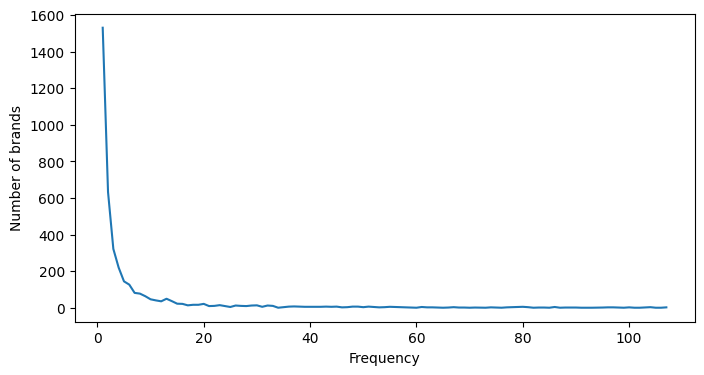

In [ ]:
# График числа брендов определенной частоты (100 наименее частых)

brand_counts = train["brand_name"].value_counts(dropna=True)
freq_counts = brand_counts.value_counts().sort_index().iloc[:100]
plt.figure(figsize=(8, 4))
plt.plot(freq_counts.index, freq_counts.values)
plt.xlabel("Frequency")
plt.ylabel("Number of brands")
plt.show()

Предлагаю добавить бренды с частотой <= 10 в категорию "другие" - тем самым мы сильнее всего понизим размерность

In [ ]:
print(prep.CategoryEncoder.__doc__)


    Class for category column preprocessing (Group rare categories and apply Binary Encoding).

    Args:
        col_name (str): The name of the column to encode.
        min_freq (int): Categories which frequency is below this threshold will be put in f"<RARE_{self.col_name}>" category.
    


In [ ]:
brand_name_enc = prep.CategoryEncoder(col_name="brand_name", min_freq=10)
brand_name_enc.fit(train)

print(len(brand_name_enc.frequent_categories_))

865


Из 4066 категорий оставили только 868 -> получим 10 бинарных колонок при BinaryEncoding-е.

In [ ]:
transformed_train = brand_name_enc.transform(train)
transformed_train.head(3)

,resolution,brand_name,description,name_rus,CommercialTypeName4,rating_1_count,rating_2_count,rating_3_count,rating_4_count,rating_5_count,...,brand_name_0,brand_name_1,brand_name_2,brand_name_3,brand_name_4,brand_name_5,brand_name_6,brand_name_7,brand_name_8,brand_name_9
0,0,ACTRUM,"Мешки пылесборники для пылесоса PHILIPS, 10 шт...","Мешки для пылесоса PHILIPS TRIATLON, синтетиче...",Пылесборник,6.0,4.0,4.0,3.0,32.0,...,0,0,0,0,0,0,0,0,0,1
1,0,Red Line,Защитная силиконовая крышка обьектива GoPro He...,Защитная крышка Redline на экшн-камеру GoPro (...,Крышка для объектива,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
2,0,<RARE_BRAND_NAME>,Плоский медиатор из кости толщиной 0.6 мм<br/>...,Медиатор для гитары Acura GP-PB6,Аксессуар для музыкального инструмента,0.0,0.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,1,1


In [ ]:
for c in transformed_train.columns:
    if c.startswith("brand_name"):
        print(c)

brand_name
brand_name_0
brand_name_1
brand_name_2
brand_name_3
brand_name_4
brand_name_5
brand_name_6
brand_name_7
brand_name_8
brand_name_9


### CommercialTypeName4

In [ ]:
# Посмотрим на CommercialTypeName4

print("Train 'CommercialTypeName4':")
analyze_string_columns(train.CommercialTypeName4)
print()
print("Test 'CommercialTypeName4':")
analyze_string_columns(test.CommercialTypeName4)

Train 'CommercialTypeName4':
count: 197198
n_nan: 0
n_empty: 0
n_non_empty: 197198
length_min: 3
length_max: 64
length_mean: 23.257325125001266
length_median: 21.0
length_std: 8.98699381155549

Test 'CommercialTypeName4':
count: 22760
n_nan: 0
n_empty: 0
n_non_empty: 22760
length_min: 3
length_max: 64
length_mean: 21.548022847100174
length_median: 21.0
length_std: 9.088270767321301


In [ ]:
print("Train 'CommercialTypeName4' unique count:", train["CommercialTypeName4"].nunique())
print("Test 'CommercialTypeName4' unique count:", test["CommercialTypeName4"].nunique())

print("\nTop 5 popular 'CommercialTypeName4' in train:")
print(train["CommercialTypeName4"].value_counts(dropna=True).head(5))

print("\nTop 5 popular 'CommercialTypeName4' in test:")
print(test["CommercialTypeName4"].value_counts(dropna=True).head(5))

Train 'CommercialTypeName4' unique count: 634
Test 'CommercialTypeName4' unique count: 440

Top 5 popular 'CommercialTypeName4' in train:
CommercialTypeName4
Дисплеи для телефонов                  15002
Аккумулятор для мобильного телефона    11965
Корпуса для телефонов                  11960
Запчасти для телевизора                10192
Картридж, чернила, тонер                8570
Name: count, dtype: int64

Top 5 popular 'CommercialTypeName4' in test:
CommercialTypeName4
Настольный компьютер                   1856
Водонагреватель накопительный           783
Картридж, чернила, тонер                701
Электрическая зубная щетка              698
Аккумулятор для мобильного телефона     697
Name: count, dtype: int64


In [ ]:
count_and_percentage_in(test.CommercialTypeName4, train.CommercialTypeName4)

(np.int64(22737), np.float64(99.89894551845343))

Почти 100% категорий в тесте есть в трейне.

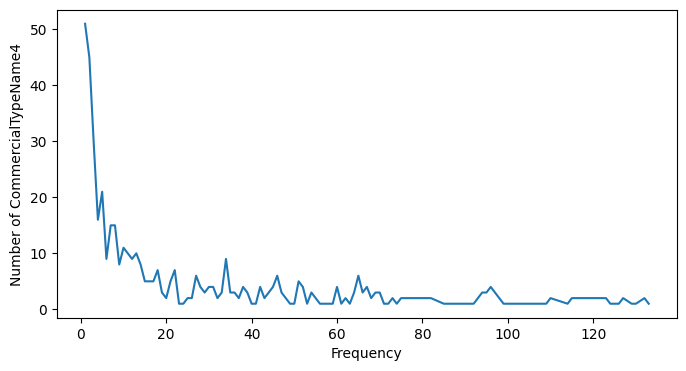

In [ ]:
# График числа брендов определенной частоты (100 наименее частых)

brand_counts = train["CommercialTypeName4"].value_counts(dropna=True)
freq_counts = brand_counts.value_counts().sort_index().iloc[:100]
plt.figure(figsize=(8, 4))
plt.plot(freq_counts.index, freq_counts.values)
plt.xlabel("Frequency")
plt.ylabel("Number of CommercialTypeName4")
plt.show()

Сделаем отсечку на 10.

In [ ]:
CommercialTypeName4_enc = prep.CategoryEncoder(col_name="CommercialTypeName4", min_freq=10)
CommercialTypeName4_enc.fit(train)

print(len(CommercialTypeName4_enc.frequent_categories_))

424


Из 634 оставили 424 категории -> получим 9 бинарных колонок.

In [ ]:
transformed_train = CommercialTypeName4_enc.transform(train)
transformed_train.head(3)

,resolution,brand_name,description,name_rus,CommercialTypeName4,rating_1_count,rating_2_count,rating_3_count,rating_4_count,rating_5_count,...,has_brand_name,CommercialTypeName4_0,CommercialTypeName4_1,CommercialTypeName4_2,CommercialTypeName4_3,CommercialTypeName4_4,CommercialTypeName4_5,CommercialTypeName4_6,CommercialTypeName4_7,CommercialTypeName4_8
0,0,ACTRUM,"Мешки пылесборники для пылесоса PHILIPS, 10 шт...","Мешки для пылесоса PHILIPS TRIATLON, синтетиче...",Пылесборник,6.0,4.0,4.0,3.0,32.0,...,1,0,0,0,0,0,0,0,0,1
1,0,Red Line,Защитная силиконовая крышка обьектива GoPro He...,Защитная крышка Redline на экшн-камеру GoPro (...,Крышка для объектива,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,1,0
2,0,Talwar Brothers,Плоский медиатор из кости толщиной 0.6 мм<br/>...,Медиатор для гитары Acura GP-PB6,Аксессуар для музыкального инструмента,0.0,0.0,1.0,0.0,1.0,...,1,0,0,0,0,0,0,0,1,1


In [ ]:
for c in transformed_train.columns:
    if c.startswith("CommercialTypeName4"):
        print(c)

CommercialTypeName4
CommercialTypeName4_0
CommercialTypeName4_1
CommercialTypeName4_2
CommercialTypeName4_3
CommercialTypeName4_4
CommercialTypeName4_5
CommercialTypeName4_6
CommercialTypeName4_7
CommercialTypeName4_8


### SellerID

Делаем такое же преобразование категориальной в бинарные (как и brand_name)

In [ ]:
# Посмотрим на SellerID

print("Train 'SellerID':")
analyze_string_columns(train.SellerID)
print()
print("Test 'SellerID':")
analyze_string_columns(test.SellerID)

Train 'SellerID':
count: 197198
n_nan: 0
n_empty: 0
n_non_empty: 197198

Test 'SellerID':
count: 22760
n_nan: 0
n_empty: 0
n_non_empty: 22760


In [ ]:
print("Train 'SellerID' unique count:", train["SellerID"].nunique())
print("Test 'SellerID' unique count:", test["SellerID"].nunique())

print("\nTop 5 popular 'SellerID' in train:")
print(train["SellerID"].value_counts(dropna=True).head(5))

print("\nTop 5 popular 'SellerID' in test:")
print(test["SellerID"].value_counts(dropna=True).head(5))

Train 'SellerID' unique count: 11167
Test 'SellerID' unique count: 2952

Top 5 popular 'SellerID' in train:
SellerID
24     6172
69     3532
442    3009
6      2945
27     2016
Name: count, dtype: int64

Top 5 popular 'SellerID' in test:
SellerID
467    1152
576     776
9       687
804     311
128     245
Name: count, dtype: int64


In [ ]:
count_and_percentage_in(test.SellerID, train.SellerID)

(np.int64(14837), np.float64(65.18892794376099))

Только 65% продавцов в тесте присутствуют в трейне.

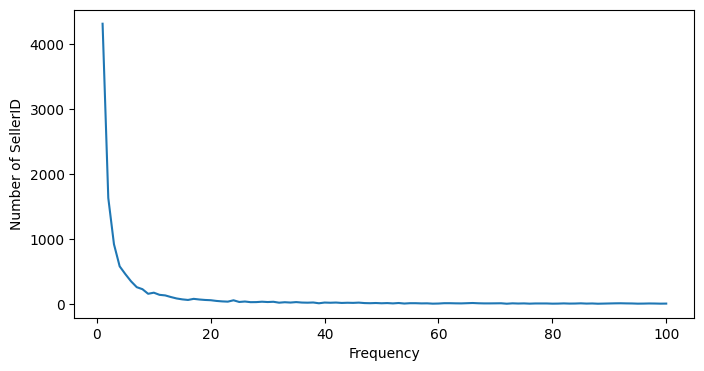

In [ ]:
# График числа брендов определенной частоты (100 наименее частых)

brand_counts = train["SellerID"].value_counts(dropna=True)
freq_counts = brand_counts.value_counts().sort_index().iloc[:100]
plt.figure(figsize=(8, 4))
plt.plot(freq_counts.index, freq_counts.values)
plt.xlabel("Frequency")
plt.ylabel("Number of SellerID")
plt.show()

Сделаем отсечку на 15.

In [ ]:
# Преобразуем числовой SellerID в стринг
train["SellerID"] = train["SellerID"].astype(str)
test["SellerID"] = test["SellerID"].astype(str)

In [ ]:
SellerID_enc = prep.CategoryEncoder(col_name="SellerID", min_freq=15)
SellerID_enc.fit(train)

print(len(SellerID_enc.frequent_categories_))

1666


Из 11167 оставили 1666 продавцов -> получим 11 бинарных колонок.

In [ ]:
transformed_train = SellerID_enc.transform(train)
transformed_train.head(3)

,resolution,brand_name,description,name_rus,CommercialTypeName4,rating_1_count,rating_2_count,rating_3_count,rating_4_count,rating_5_count,...,SellerID_1,SellerID_2,SellerID_3,SellerID_4,SellerID_5,SellerID_6,SellerID_7,SellerID_8,SellerID_9,SellerID_10
0,0,ACTRUM,"Мешки пылесборники для пылесоса PHILIPS, 10 шт...","Мешки для пылесоса PHILIPS TRIATLON, синтетиче...",Пылесборник,6.0,4.0,4.0,3.0,32.0,...,0,0,0,0,0,0,0,0,0,1
1,0,Red Line,Защитная силиконовая крышка обьектива GoPro He...,Защитная крышка Redline на экшн-камеру GoPro (...,Крышка для объектива,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
2,0,Talwar Brothers,Плоский медиатор из кости толщиной 0.6 мм<br/>...,Медиатор для гитары Acura GP-PB6,Аксессуар для музыкального инструмента,0.0,0.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,1,1


In [ ]:
for c in transformed_train.columns:
    if c.startswith("SellerID"):
        print(c)

SellerID
SellerID_0
SellerID_1
SellerID_2
SellerID_3
SellerID_4
SellerID_5
SellerID_6
SellerID_7
SellerID_8
SellerID_9
SellerID_10


## Числовые фичи

Препроцессинг числовых фичей будет следующий:

- Смотрим на распределение и определяем надо ли применять лог.
- Применяем StandardScaler.
- Заменяем все NaN на -1.

In [ ]:
len(numeric_cols)

37

In [ ]:
for col in numeric_cols:
    train_neg = (train[col] < 0).sum()
    test_neg = (test[col] < 0).sum()
    assert train_neg == test_neg == 0

Все значения положительные - значит применять log можем спокойно.

### Последовательно смотрим на каждую колонку

Mean: 0.06
Median: 0.00
Standard Deviation: 1.20
Missing Values: 0
Percentage of NaN: 0.00%


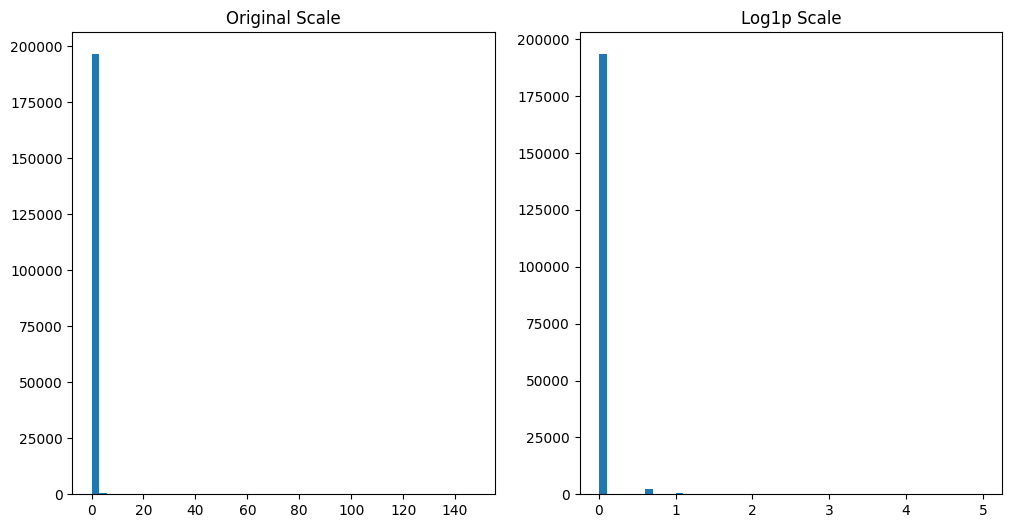

In [ ]:
col_name = "item_count_fake_returns90"

analyze_numeric_series(train[col_name], bins=50)

In [ ]:
print(prep.NumericEncoder.__doc__)


    Class for numeric column preprocessing:

    - Apply np.log1p if required
    - Apply StandardScaler
    - Fill missing values

    Args:
        col_name (str): The name of the column to encode.
        apply_log (bool): Whether to apply np.log1p to the column.
        filling_value (float): The value to use for filling missing values.
    


In [ ]:
ne = prep.NumericEncoder(col_name=col_name, apply_log=True)
ne.fit(train)

ne._scaler.mean_, ne._scaler.scale_

(array([6.04623352]), array([1.28401623]))

In [ ]:
transformed_train = ne.transform(train)
for c in transformed_train.columns:
    if c.startswith(col_name):
        print(c)

seller_time_alive


Stats Without -1
Mean: 0.00
Median: 0.28
Standard Deviation: 1.00
Missing Values: 0
Percentage of NaN: 0.00%


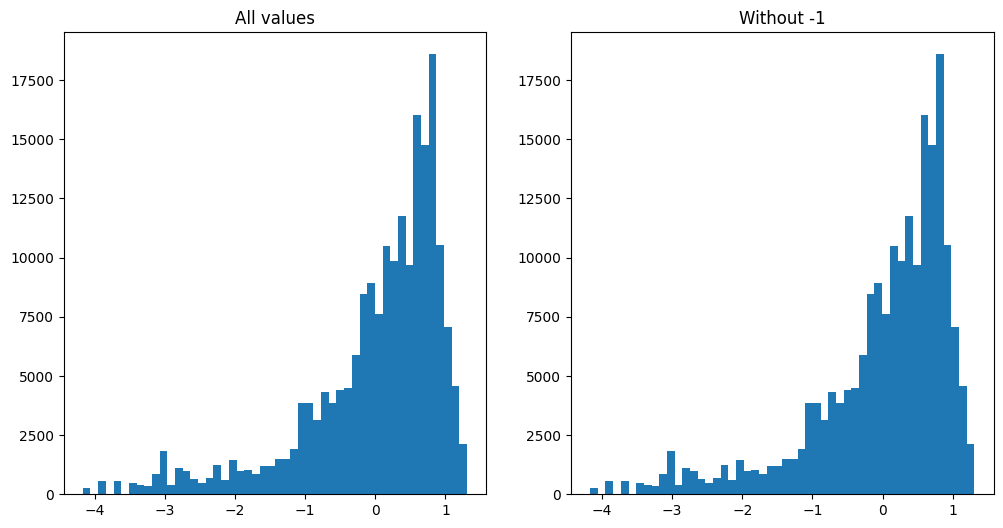

In [ ]:
analyze_numeric_series(transformed_train[col_name], after_transform=True, bins=50)